In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 

df = pd.read_pickle('dataset/train_dataset.pkl')


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

<AxesSubplot:>

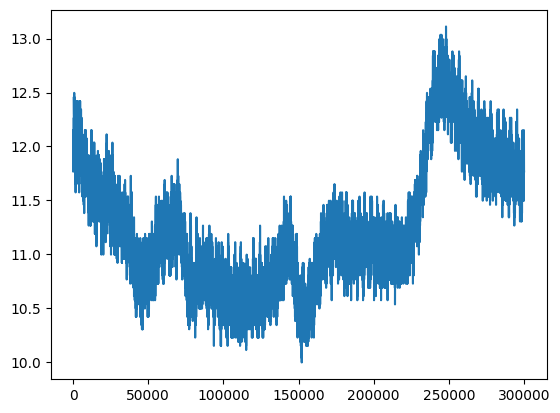

In [6]:
df['AIT504'].iloc[0:300000].plot()

In [11]:

def get_train_test_dataset(df):
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test

In [3]:
train, test = get_train_test_dataset(df)
test = test.reset_index(drop=True)

train['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)
test['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)


## Create Sate

In [15]:
cols_continuous_tank = ['LIT101', 'LIT301', 'LIT401']

HH=1000
H=800
L=500 
LL=250

def get_level_tank(tank):
    if tank <= LL:
        return 1
    elif tank > LL and tank <= L:
        return 2
    elif tank > L and tank <= H:
        return 3
    elif tank > H and tank <= HH:
        return 4
    elif tank > HH:
        return 5
        

# create discrete variables for the tank levels
for col in cols_continuous_tank:
    df[f'{col}_discrete'] = df[col].apply(get_level_tank)
    

In [16]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

for col in cols_continuous_tank:
    cols_numeric.remove(col)

cols_discrete = []
cols_continous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continous.append(col)

for col in cols_continuous_tank:
    cols_discrete.remove(f'{col}_discrete')

# Get State by slope

In [ ]:
[0, 0, 0, 0, 1, -1]

In [79]:
df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P402,P403,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Normal/Attack,index,attack,LIT101_discrete,LIT301_discrete,LIT401_discrete,FIT101_discrete,AIT201_discrete,AIT202_discrete,AIT203_discrete,FIT201_discrete,DPIT301_discrete,FIT301_discrete,AIT401_discrete,AIT402_discrete,FIT401_discrete,AIT501_discrete,AIT502_discrete,AIT503_discrete,AIT504_discrete,FIT501_discrete,FIT502_discrete,FIT503_discrete,FIT504_discrete,PIT501_discrete,PIT502_discrete,PIT503_discrete,FIT601_discrete,MV101_discrete,P101_discrete,P102_discrete,MV201_discrete,P201_discrete,P203_discrete,P204_discrete,P205_discrete,P206_discrete,MV301_discrete,MV302_discrete,MV303_discrete,MV304_discrete,P301_discrete,P302_discrete,P402_discrete,P403_discrete,UV401_discrete,P501_discrete,P602_discrete,Normal/Attack_discrete,LIT101_discrete_discrete,LIT301_discrete_discrete,LIT401_discrete_discrete
0,2015-12-22 20:00:00,2.455882,643.3135,2,2,1,262.2404,8.381056,442.6301,2.470509,2,1,2,1,1,1,0.044817,0.000000,895.3234,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.6665,2,1,2,7.861638,184.6193,269.7065,11.95847,1.712125,1.281158,0.739110,0.308426,2,253.3645,1.329574,192.5628,1.696537,2,Normal,14400,0,3,4,4,2,2,3,4,4,1,1,1,4,2,2,4,3,3,2,3,3,3,3,4,3,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,0,3,4,4
1,2015-12-22 20:00:01,2.431861,643.6667,2,2,1,262.2404,8.381056,442.5019,2.470509,2,1,2,1,1,1,0.044817,0.000000,895.9241,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.0128,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.282567,0.739110,0.308426,2,253.3004,1.329574,192.5628,1.723064,2,Normal,14401,0,3,4,4,2,2,3,4,4,1,1,1,4,2,2,4,3,3,2,3,3,3,3,4,3,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,0,3,4,4
2,2015-12-22 20:00:02,2.425135,643.6667,2,2,1,262.2404,8.381056,442.5019,2.470509,2,1,2,1,1,1,0.044817,0.000000,896.0443,2,1,2,1,1,1,0.0000,197.4878,1.701855,850.2051,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.282567,0.739110,0.308426,2,253.2844,1.329574,192.5628,1.729536,2,Normal,14402,0,3,4,4,2,2,3,4,4,1,1,1,4,2,2,4,3,3,2,3,3,3,3,4,3,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,0,3,4,4
3,2015-12-22 20:00:03,2.423213,644.3733,2,2,1,262.2404,8.381056,442.4507,2.470509,2,1,2,1,1,1,0.044817,0.000256,897.2059,2,1,2,1,1,1,0.0000,197.4878,1.701855,849.7437,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.297297,0.739110,0.308747,2,253.2844,1.329574,192.4987,1.737545,2,Normal,14403,0,3,4,4,2,2,3,4,4,1,1,1,4,2,2,4,3,3,2,4,3,3,3,4,3,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,0,3,4,4
4,2015-12-22 20:00:04,2.439548,644.5303,2,2,1,262.2404,8.381056,442.2199,2.470509,2,1,2,1,1,1,0.044817,0.000256,897.3661,2,1,2,1,1,1,0.0000,197.4878,1.703649,849.5514,2,1,2,7.861638,184.6193,269.7065,11.95847,1.711484,1.297297,0.739110,0.308939,2,253.2844,1.329574,192.4987,1.737545,2,Normal,14404,0,3,4,4,2,2,3,4,4,1,1,1,4,2,2,4,3,3,2,4,3,3,3,4,3,4,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2,0,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932314,2016-01-02 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,2,1,2,1,20.398230,2.196586,974.5498,1,2,1,1,1,2,148.8032,145.6037,1.705315,956.8701,2,1,2,7.745642,139.1182,257.1136,14.80390,1.716483,1.288971,0.734885,0.306569,2,251.1535,0.865024,189.0220,0.000000,1,Normal,946714,0,3,4,4,3,1,4,1,4,4,1,1,1,2,1,1,1,4,2,3,2,1,2,1,2,1,2,2,1,2,2,2,1,2,1,1,2,1,1,1,2,2,1,2,2,1,0,3,4,4
932315,2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,2,2,1,2,1,2

In [159]:
df['LIT101'].iloc[5+1:8+1]

6    645.1583
7    645.1191
8    645.3546
Name: LIT101, dtype: float64

In [165]:
TIME_WINDOW = 5
df['LIT101_slope'] = 0
x = [i for i in range(TIME_WINDOW)]
index = 0
for i in range(30):
    index =  TIME_WINDOW + i  # i=0 ->index=3
    # sequence = pd.Series(df['LIT101'].iloc[(index - TIME_WINDOW)+1: index+1])  # i=0 ->iloc[0:3]
    # p = np.polyfit(x, sequence , 1)
    # slope = 1 if p[0] > 0 else -1
    df['LIT101_slope'].iloc[index] = 1 if np.polyfit(x, pd.Series(df['LIT101'].iloc[(index - TIME_WINDOW)+1: index+1]) , 1)[0] > 0 else -1 # index = 3

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_39707/2655921277.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LIT101_slope'].iloc[index] = 1 if np.polyfit(x, pd.Series(df['LIT101'].iloc[(index - TIME_WINDOW)+1: index+1]) , 1)[0] > 0 else -1 # index = 3


In [155]:
-9.572660901218564e-14

-9.572660901218564e-14

<AxesSubplot:>

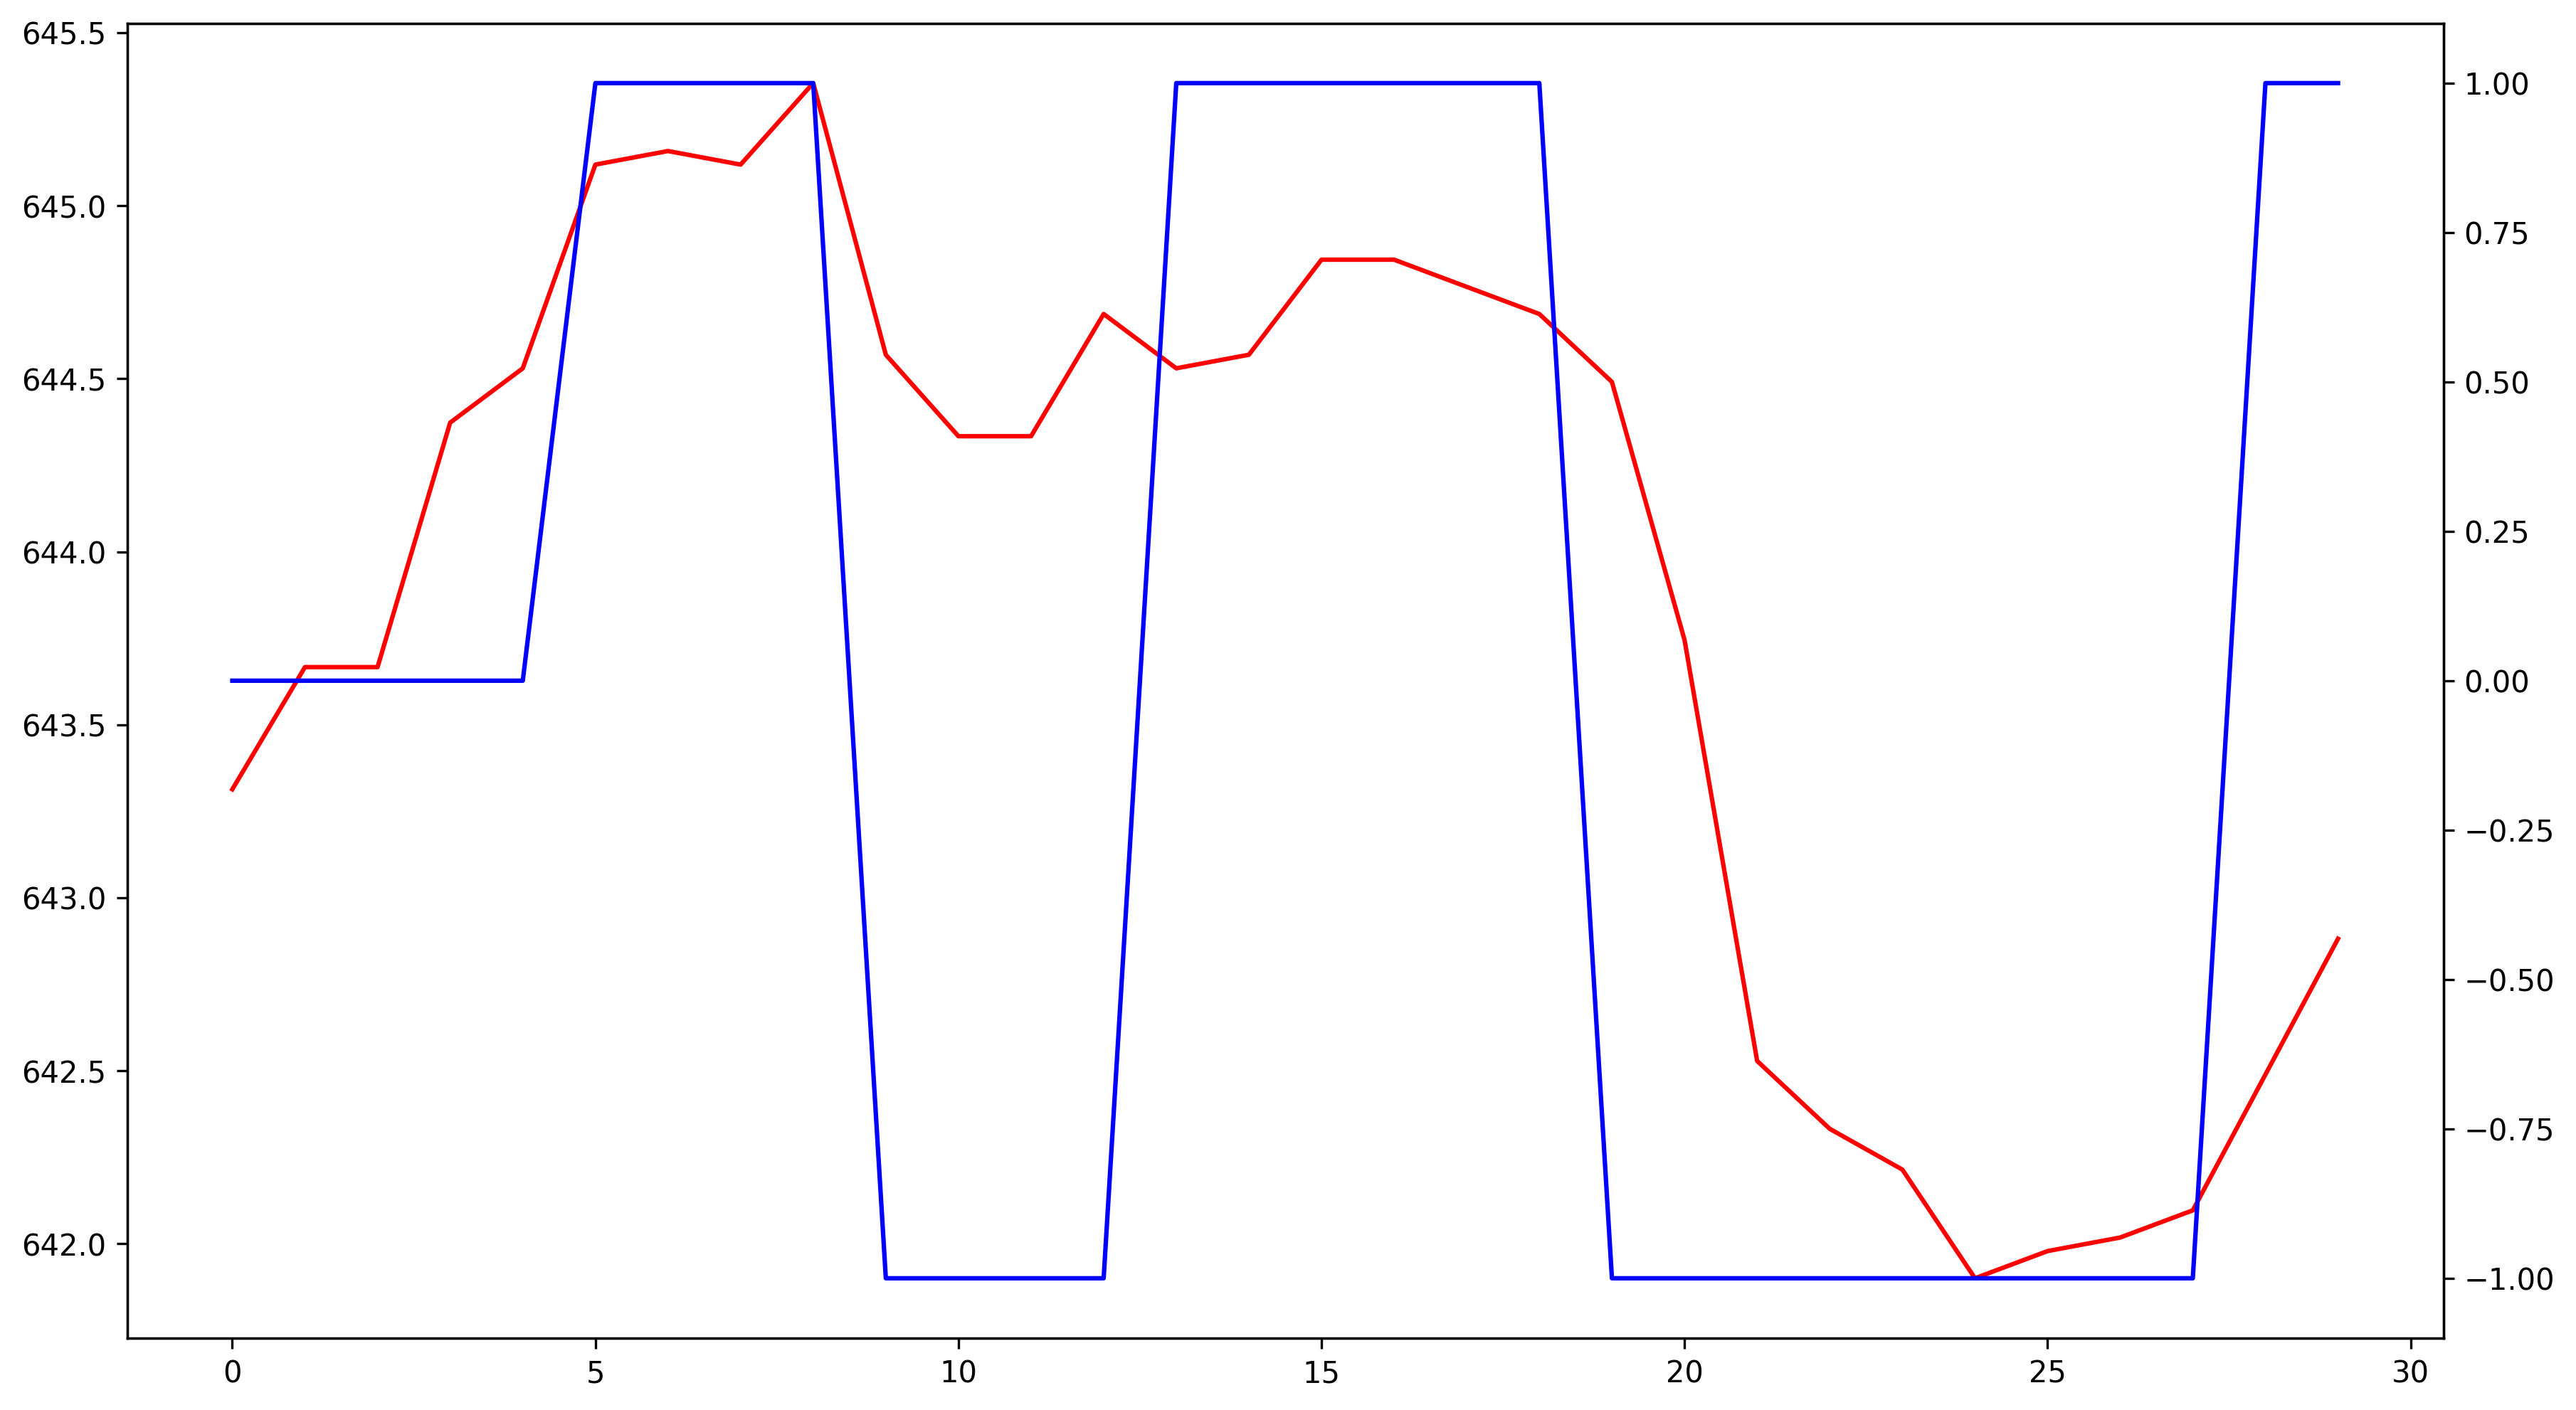

In [166]:
fig,ax = plt.subplots(figsize=(14,8), dpi=300)
ax2 = ax.twinx()
time_range = 30
df['LIT101'].iloc[0: time_range].plot(ax=ax, color='red')
df['LIT101_slope'].iloc[0: time_range].plot(ax=ax2, color='blue')

So loooong

In [169]:
TIME_WINDOW = 5

x = [i for i in range(TIME_WINDOW)]

for col in cols_continous:
    df[f'{col}_slope'] = 0
    print(col)
    for i in range(TIME_WINDOW, len(df[col])):
        df[f'{col}_slope'].iloc[TIME_WINDOW + i] = 1 if np.polyfit(x, pd.Series(df[col].iloc[i + 1: TIME_WINDOW + i +1]) , 1)[0] > 0 else -1


FIT101


/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_39707/2231059037.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_slope'].iloc[TIME_WINDOW + i] = 1 if np.polyfit(x, pd.Series(df[col].iloc[i + 1: TIME_WINDOW + i +1]) , 1)[0] > 0 else -1 # index = 3


KeyboardInterrupt: 

# Get State by quantiles

In [6]:

def get_state(row, quantiles):
    if row <= quantiles[0.25]:
        return 1
    elif row > quantiles[0.25] and row <= quantiles[0.5]:
        return 2
    elif row > quantiles[0.5] and row <= quantiles[0.75]:
        return 3
    elif row > quantiles[0.75]:
        return 4
        
# create discrete variables for the continuous variables based on the quantiles of train set
for col in cols_continous:
    quantiles = train[col].quantile([0.25, 0.5, 0.75])
    df[f'{col}_discrete'] = df[col].apply(lambda x: get_state(x, quantiles))
# ~9 mins

In [ ]:

# def get_state(row, mean):
#     if row <= mean:
#         return 1
#     elif row > mean:
#         return 2
        
        
# # create discrete variables for the continuous variables
# for col in cols_continous:
#     mean = np.mean(train[col])
#     df[f'{col}_discrete'] = df[col].apply(lambda x: get_state(x, mean))


In [7]:
for col in cols_discrete:
    df[f'{col}_discrete'] = df[col]

In [8]:
df['Normal/Attack_discrete'] = df['Normal/Attack_discrete'].apply(lambda x: 0 if x == 'Normal' else 1)

In [ ]:
for col in df.columns:
    if 'discrete' in col:
        print(col)
        print(df[col].value_counts())
        print('------------------------')

## Analysis State

In [170]:
train, test = get_train_test_dataset(df)

In [171]:
data = pd.DataFrame(columns=['col','quantile 0.05','quantile 0.25','quantile 0.5','quantile 0.75','quantile 0.95','quantile_var','polynom coef','min','max','mean','median','variance',])
for col in cols_continous:
    p = np.polyfit([ i for i in range(len(df[col]))], df[col], 1)
    dict = {'col': col, 
            'quantile 0.05': np.quantile(df[col], 0.05),
            'quantile 0.25': np.quantile(df[col], 0.25),
            'quantile 0.5': np.quantile(df[col], 0.5),
            'quantile 0.75': np.quantile(df[col], 0.75),
            'quantile 0.95': np.quantile(df[col], 0.95),
            'quantile_var': np.var(np.quantile(df[col], [0.25, 0.5, 0.75])), 
            'polynom coef': p[0] * 100000,
            'min': np.min(df[col]), 
            'max': np.max(df[col]),
            'mean': np.mean(df[col]), 
            'median': np.median(df[col]),
            'variance': np.var(df[col]),}
    data = pd.concat([data, pd.DataFrame(dict, index=[0])], axis=0, ignore_index=True)

In [172]:
data_columns = list(data.columns)
data_columns.remove('col')
for col in data_columns:
    data[col] = data[col].apply(lambda x: np.round(x, 4))

In [173]:
data['to_delete'] = data['quantile_var'] < 2
data.sort_values(by=['col'], ascending=False)

,col,quantile 0.05,quantile 0.25,quantile 0.5,quantile 0.75,quantile 0.95,quantile_var,polynom coef,min,max,mean,median,variance,to_delete
20,PIT503,184.6962,187.3558,189.1342,192.0661,194.7738,3.7717,-3.1191,3.1402,198.2985,183.3793,189.1342,1162.3892,False
19,PIT502,0.7689,0.9611,1.0893,1.2174,1.6019,0.0109,-0.0481,0.0000,1.9703,1.1012,1.0893,0.1078,True
18,PIT501,245.4980,248.7023,250.5928,253.2203,256.1202,3.4322,-3.7335,9.4687,260.0936,242.6825,250.5928,1948.3872,False
21,FIT601,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000,0.0004,0.0000,1.8027,0.0153,0.0000,0.0236,True
17,FIT504,0.3043,0.3066,0.3068,0.3084,0.3106,0.0000,-0.0044,0.0000,0.3139,0.2964,0.3068,0.0033,True
16,FIT503,0.7284,0.7323,0.7349,0.7392,0.7442,0.0000,-0.0106,0.0000,0.7522,0.7100,0.7349,0.0182,True
15,FIT502,1.2380,1.2657,1.2819,1.2945,1.3127,0.0001,-0.0133,0.0000,1.3620,1.2375,1.2819,0.0551,True
14,FIT501,1.6974,1.7144,1.7238,1.7319,1.7430,0.0001,-0.0199,0.0000,1.7578,1.6637,1.7238,0.0990,True
9,FIT401,1.6880,1.7043,1.7136,1.7226,1.7321,0.0001,-0.0203,0.0000,1.7479,1.6524,1.7136,0.1010,True
6,FIT301,0.0000,2.1971,2.2086,2.2145,2.2204,0.0001,-0.0204,0.0000,2.3762,1.7767,2.2086,0.7514,True


Set The feature selection 

In [ ]:
# discrete_cols = []
# for col in df.columns:
#     if 'discrete' in col and 'FIT' not in col:
#         discrete_cols.append(col)
# discrete_cols.remove('Normal/Attack_discrete')

In [24]:
discrete_cols = []
for col in df.columns:
    if 'discrete' in col:
        discrete_cols.append(col)
discrete_cols.remove('Normal/Attack_discrete')

for i in range(len(data)):
    col = data.iloc[i]['col']+'_discrete'
    to_delete = data.iloc[i]['to_delete']
    if to_delete:
        discrete_cols.remove(col)

In [20]:
df_discrete = df[discrete_cols + ['Timestamp'] + ['Normal/Attack_discrete']]

In [ ]:
# df_discrete.to_csv('df_discrete.csv', index=False)

## Common State between Train and Test

In [ ]:
print('train states: ', len(train[discrete_cols].value_counts()))
print('test states: ', len(test[discrete_cols].value_counts()))
print('total states: ', len(df[discrete_cols].value_counts()))
print('state in common', (len(train[discrete_cols].value_counts())+len(test[discrete_cols].value_counts()))-len(df[discrete_cols].value_counts()))
print('percentage of common:', ((len(train[discrete_cols].value_counts())+len(test[discrete_cols].value_counts()))-len(df[discrete_cols].value_counts())) / len(df[discrete_cols].value_counts()))

train states:  4286
test states:  3041
total states:  7038
state in common 289
percentage of common: 0.04106280193236715


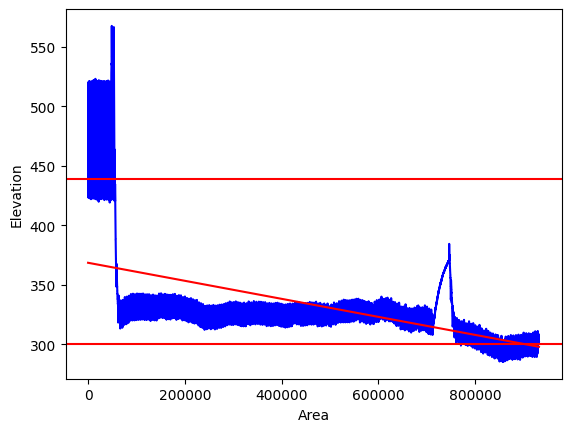

In [ ]:
target = 'AIT203'

Elv = df[target]
area = [ i for i in range(len(Elv))]

p= np.polyfit(area, Elv, 1)
plt.plot(area, Elv, 'b-')
plt.plot(area,np.polyval(p, area), 'r-')
plt.xlabel('Area')
plt.ylabel('Elevation')
plt.axhline(y=np.quantile(df[target], 0.05), color='r', linestyle='-')
plt.axhline(y=np.quantile(df[target], 0.95), color='r', linestyle='-')

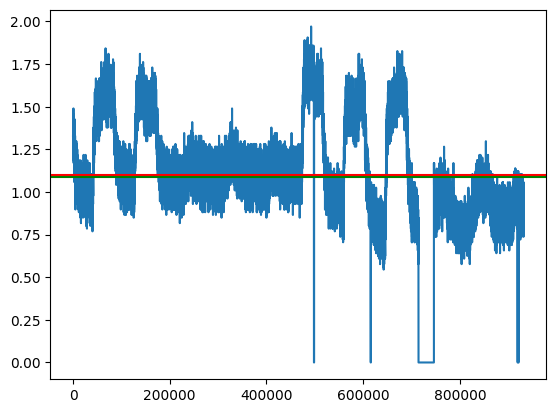

In [ ]:
target = 'PIT502'

df[target].plot()
plt.axhline(np.mean(df[target]), color='r')
plt.axhline(np.median(df[target]), color='g')
# plt.ylim(140, 200)

In [ ]:
# df.to_pickle('dataset/train_dataset_discrete.pkl')

In [2]:
df_discrete = pd.read_pickle('dataset/train_dataset_discrete.pkl')

In [23]:
df = df_discrete.copy()

## Analysing total number of State in the dataset

In [ ]:
train, test = get_train_test_dataset(df_discrete)

In [ ]:
len(train[['LIT101_discrete',  'LIT301_discrete',  'LIT401_discrete',  'FIT101_discrete']].value_counts().reset_index(name='counts'))

54

In [ ]:
for col in discrete_cols:
    column = discrete_cols.copy()
    column.remove(col)
    print(col, len(train[column].value_counts().reset_index(name='counts')))

## Test by moving average

In [ ]:
moving_average = 1000
target = 'AIT203'

moving_avg = []
df_m = df.copy()
df_m = df_m.iloc[0:200000]

for i in range(len(df_m)-moving_average):
    mean_4 = np.mean(df_m[target].iloc[i:i+moving_average])
    moving_avg.append(mean_4)

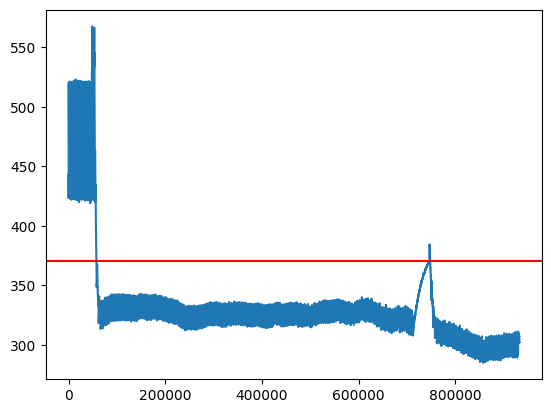

In [ ]:
plt.plot(df[target])
plt.axhline(y=np.mean(moving_avg), color='r', linestyle='-')


In [ ]:
np.mean(df[target].iloc[0:90000])

417.58270639555553

In [ ]:
np.mean(moving_avg)

370.86758272618533

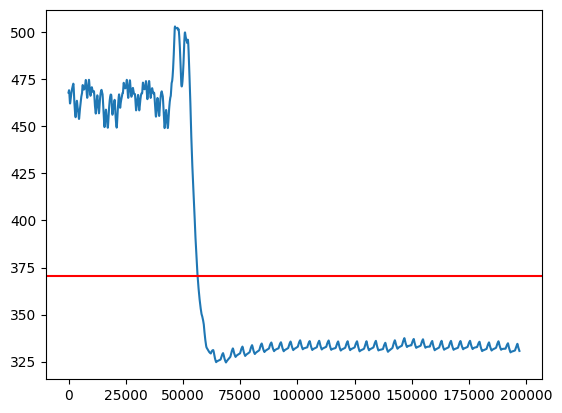

In [ ]:
plt.plot(moving_avg)
plt.axhline(y=np.mean(moving_avg), color='r', linestyle='-')


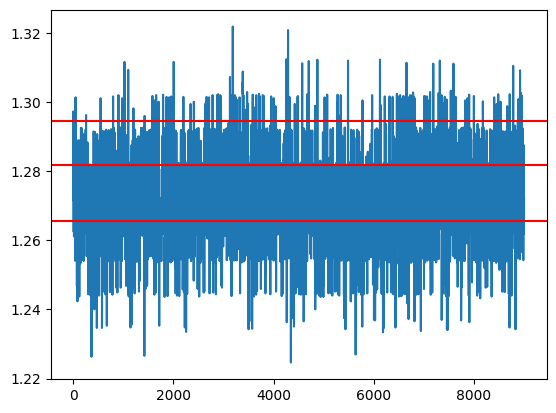

In [ ]:
plt.plot(df_m['FIT502'])
plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[0], color='r', linestyle='-')
plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[1], color='r', linestyle='-')
plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[2], color='r', linestyle='-')


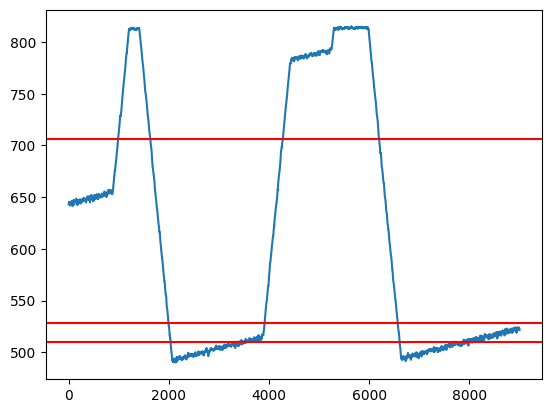

In [ ]:
plt.plot(df_m['LIT101'])
plt.axhline(y=np.quantile(df['LIT101'], [0.25, 0.5, 0.75])[0], color='r', linestyle='-')
plt.axhline(y=np.quantile(df['LIT101'], [0.25, 0.5, 0.75])[1], color='r', linestyle='-')
plt.axhline(y=np.quantile(df['LIT101'], [0.25, 0.5, 0.75])[2], color='r', linestyle='-')

In [ ]:
np.min(df['LIT101'])

189.8263

In [ ]:
np.max(df['LIT101'])

925.0323

In [ ]:

HH=1000
H=800
L=500 
LL=250


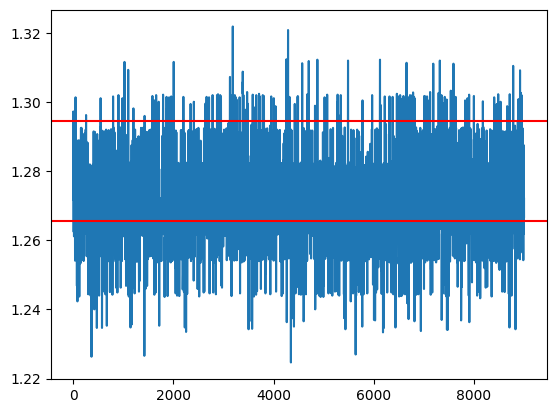

In [ ]:
plt.plot(df_m['FIT502'])
plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[0], color='r', linestyle='-')
# plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[1], color='r', linestyle='-')
plt.axhline(y=np.quantile(df['FIT502'], [0.25, 0.5, 0.75])[2], color='r', linestyle='-')


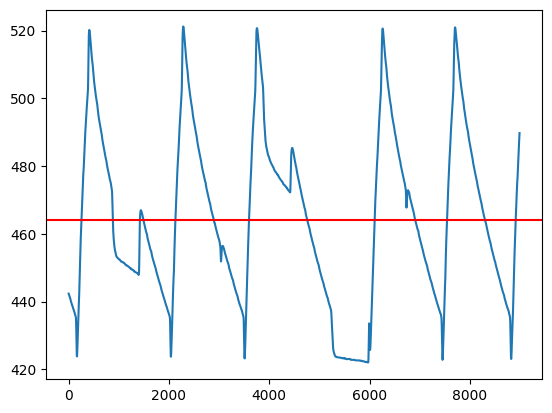

In [ ]:
plt.plot(LIT101_moving_avg)
plt.axhline(y=np.mean(LIT101_moving_avg), color='r', linestyle='-')


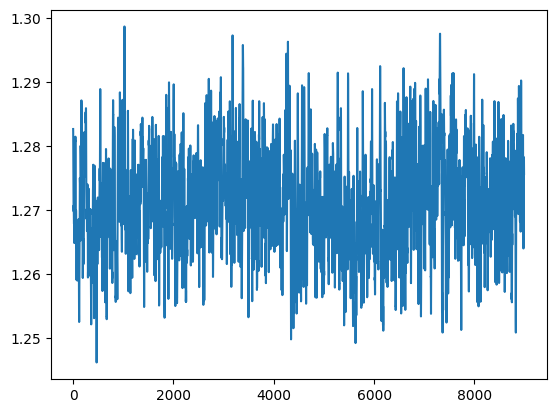

In [ ]:
plt.plot(LIT101_moving_avg)

In [ ]:
np.mean(df['FIT502'])

1.2375254528541393

Number of total existing state in the df dataset

In [ ]:
len(df_discrete[discrete_cols].value_counts())

307885

Number of total existing state in the training dataset

In [ ]:
len(train[discrete_cols].value_counts())

204481

In [ ]:
len(test[discrete_cols].value_counts())

103445

# Sequencing 

In [25]:
def set_sequence(row):
    sequence = str('')
    for value in row:
        sequence += str(value)
    return sequence

In [26]:
df_discrete['state'] = df_discrete[discrete_cols].apply(lambda row: set_sequence(row), axis=1)

In [29]:
train_discrete, test_discrete = get_train_test_dataset(df_discrete)

In [32]:
count_states = pd.DataFrame(columns=['state', 'time'])
list_of_states = []

for i in range(len(train_discrete)):
    if train_discrete['state'].iloc[i] not in list_of_states:
        count_states = pd.concat(objs=[count_states, pd.DataFrame({'state': train_discrete['state'].iloc[i], 'time': [train_discrete['Timestamp'].iloc[i]]})], axis=0)
        list_of_states.append(train_discrete['state'].iloc[i])

In [36]:
count_states = count_states.reset_index(drop=True)

In [44]:
count_states['count_state'] = count_states.index

<AxesSubplot:xlabel='time', ylabel='count_state'>

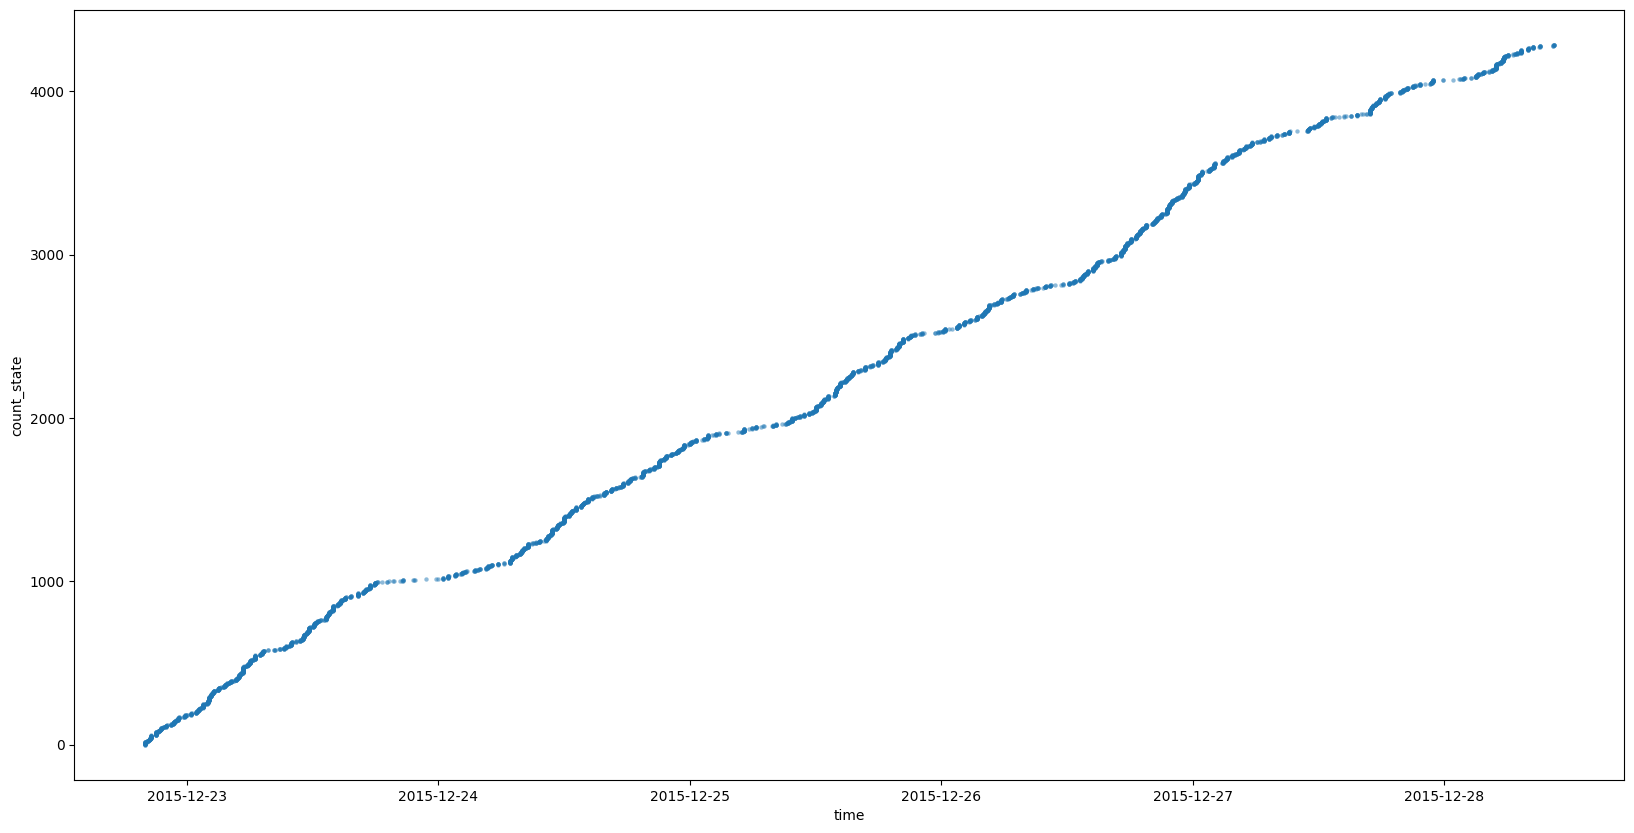

In [46]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=count_states, s=10, alpha=0.5, marker='o', linewidth=0)


In [34]:
len(list_of_states)

4286

In [26]:
known_state = train_discrete['state'].unique()
known_state = pd.DataFrame(known_state, columns=['state']).sort_values(by=['state']).reset_index(drop=True)

In [31]:
known_state_full = train_discrete[discrete_cols].drop_duplicates().reset_index(drop=True)

In [28]:
known_state[known_state['state'] == known_state.iloc[4100]['state']]

,state
4100,453411141111111111111121121221


# LCS Simplified

In [ ]:
arr_1 = np.array(state_information.iloc[999])
arr_2 = np.array(state_information.iloc[1024])

lcs = np.sum((arr_1 == state))
lcs

In [ ]:
best_index = 0
best_lcs = 0
for i in range(len(state_information)):
    state = np.array(state_information.iloc[i])
    lcs = np.sum((arr_1 == state))
    if lcs > best_lcs:
        best_lcs = lcs
        best_index = i

print(best_lcs, best_index)

30 999


# Creation of Matrix Transition Probability

<font size="4"> $p_{i,j} = {N_{i,j} \over N_i}$ </font>

In [141]:
train_discrete, test_discrete = get_train_test_dataset(df_discrete)

In [34]:
k = len(train_discrete['state'].unique())

In [35]:
df_state = train_discrete['state'].unique()
df_state = pd.DataFrame(df_state)
df_state.columns = ['state']

df_state = df_state.sort_values(by=['state'])
df_state = df_state.reset_index(drop=True)
df_state = df_state.reset_index()

In [37]:
matrix = np.zeros((k, k), dtype=int)

In [38]:
for i in range(len(train_discrete)-1):# 450.000
    state_before = train_discrete.iloc[i]['state']
    state_after  = train_discrete.iloc[i+1]['state']
    
    false_state_before = df_state[df_state['state'] == state_before]['index'].values[0]
    false_state_after  = df_state[df_state['state'] == state_after]['index'].values[0]

    sum_state[false_state] += 1
    matrix[false_state_before][false_state_after] += 1
    
# ~34 min for 4000 states

In [ ]:
# for i in range(len(df_state)-1):# 4000
#     state = df_state.iloc[i]['state']
    
#     list_of_state = train_discrete[train_discrete['state'] == state]['index']

#     for j in range(len(list_of_state)):
#         false_state_before = list_of_state.iloc[j]
        
#         matrix[i][false_state_after] += 1
    
    
#     false_state_after  = train_discrete[train_discrete['state'] == state_after]['index'].values[0]

#     matrix[i][i+1] += 1


In [62]:
df_count_state = train_discrete['state'].value_counts().rename_axis('state').reset_index(name='counts')
df_merge_count = pd.merge(df_state, df_count_state, on='state', how='left')
sum_state = df_merge_count['counts'].values

In [73]:
transition_matrix = matrix / sum_state

In [74]:
transition_matrix = np.nan_to_num(transition_matrix)

In [188]:
df_transition_matrix = pd.DataFrame(transition_matrix)

In [195]:
# df_transition_matrix.to_pickle('markov/transition_matrix.pkl')

In [47]:
df_transition_matrix = pd.read_pickle('markov/transition_matrix.pkl')

In [71]:
# df_transition_matrix_test.to_csv('markov/transition_matrix_label.csv', index=False, header=True)

In [ ]:
adjacency_matrix = np.zeros((k, k), dtype=int)

In [63]:
df_transition_matrix_g = df_transition_matrix.copy()


In [68]:
df_transition_matrix_test = pd.concat([pd.DataFrame(df_transition_matrix.index), df_transition_matrix], axis=1)

In [61]:
test_ = df_transition_matrix.iloc[0] > 0

In [62]:
test_.sum()

4

In [ ]:
transition_matrix = np.array(df_transition_matrix)

In [81]:
df_prob = (sum_state / len(train_discrete))
df_prob = np.nan_to_num(df_prob)
df_prob = np.array(df_prob.tolist())

# Sequence probability on Test set

In [ ]:
# [4,   ?,   5]
# p1 -> ? -> ?

In [127]:
state_information = train_discrete[discrete_cols].drop_duplicates().reset_index(drop=True)

In [145]:
def get_next_state(state_):
    best_index = 0
    best_lcs = 0
    next_state = pd.DataFrame(columns=['state', 'lcs', 'index'])
    for i in range(len(state_information)):
        state = np.array(state_information.iloc[i])
        lcs = np.sum((state_ == state))
        if lcs > best_lcs:
            best_lcs = lcs
            next_state = pd.concat([next_state, pd.DataFrame([[state, lcs, i]], columns=['state', 'lcs', 'index'])])
    
    return next_state[next_state['lcs'] == best_lcs]

In [146]:
test_seq = train_discrete[discrete_cols].iloc[20000]
next_st = get_next_state(test_seq)
next_st

,state,lcs,index
0,"[3, 4, 4, 1, 4, 4, 4, 2, 3, 3, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1]",30,239


In [182]:
discrete_state = df_discrete[discrete_cols+['state']]

def get_probability_on_sequence(sequence, transition_matrix, df_prob, df_state):
    probabilities = np.zeros(len(sequence))

    state = sequence.iloc[0]
    index_previous_state = -1
    if len(df_state[df_state['state'] == state]['index']) == 0:
        test_seq = discrete_state[discrete_state['state'] == state][discrete_cols].iloc[0]
        next_st = get_next_state(test_seq)
        
        lcs = next_st['lcs'].values[0]
        index_previous_state = next_st['index'].values[0]
        proba = lcs / len(sequence)
        
        print(proba, lcs, index_previous_state, transition_matrix[index_previous_state][index_previous_state], len(next_st))
    else:
        index_previous_state = df_state[df_state['state'] == state]['index'].values[0]
    probabilities[0] = df_prob[index_previous_state]

    for i in range(1, len(sequence)):
        
        state = sequence.iloc[i]
        index = df_state[df_state['state'] == state]['index']
        
        if len(index) == 0:
            test_seq = discrete_state[discrete_state['state'] == state][discrete_cols].iloc[0]
            next_st = get_next_state(test_seq)
            
            lcs = next_st['lcs'].values[0]
            index = next_st['index'].values[0]
            proba = lcs / len(sequence)
            
            print(proba, lcs, index, transition_matrix[index_previous_state][index], len(next_st))
            
            probabilities[i] = proba * transition_matrix[index_previous_state][index]
        else:
            index = index.values[0]
            print(index, transition_matrix[index_previous_state][index])
            probabilities[i] = transition_matrix[index_previous_state][index]
            
        index_previous_state = index
        

    return probabilities

In [ ]:
test_discrete['Normal/Attack_discrete'].iloc[1000:1030]

In [180]:
sequence_test = test_discrete.iloc[1000:1030]['state']

In [183]:
probability = get_probability_on_sequence(sequence_test, transition_matrix, df_prob, df_state)

0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.7777777777777778 1
0.9666666666666667 29 3462 0.77777777777

In [184]:
probability

array([1.85891266e-05, 7.51851852e-01, 7.51851852e-01, 7.51851852e-01,
       7.51851852e-01, 7.51851852e-01, 7.51851852e-01, 7.51851852e-01,
       7.51851852e-01, 7.51851852e-01, 7.51851852e-01, 7.51851852e-01,
       7.51851852e-01, 7.51851852e-01, 7.51851852e-01, 7.51851852e-01,
       7.51851852e-01, 7.51851852e-01, 7.51851852e-01, 7.51851852e-01,
       7.51851852e-01, 0.00000000e+00, 8.52941176e-01, 8.52941176e-01,
       8.52941176e-01, 8.52941176e-01, 8.52941176e-01, 8.52941176e-01,
       8.52941176e-01, 0.00000000e+00])

In [ ]:
threshold = 0.001
if probability > threshold:
    print('Anomaly')
probability

## lol tg

### LCS (Longest Common Subsequence)

In [ ]:
def lcs(pattern_1, pattern_2):
    m = len(pattern_1)
    n = len(pattern_2)
    
    
    dp = [
        [None] * (n + 1) for item in range(m + 1)
    ]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                dp[i][j] = 0
            elif pattern_1[i - 1] == pattern_2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else :
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[m][n]

In [ ]:

best = 0
best_i = 0
pattern = known_state.iloc[top_10[1]]['state']
for i in range(len(known_state)):
    lcs_ = lcs(pattern, known_state.iloc[i]['state'])
    if lcs_ >= best:
        best = lcs_
        best_i = i
print(best, best_i)

30 343


In [ ]:
known_state.iloc[999]['state']

'344144423322121212111221121221'

In [ ]:
known_state.iloc[top_10[0]]['state']

'354212231121111111111121221221'

### SVM (Simple Vector Machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_kernels, chi2_kernel, sigmoid_kernel, laplacian_kernel, polynomial_kernel, linear_kernel, cosine_similarity, rbf_kernel


In [ ]:
state_information = train_discrete[discrete_cols].drop_duplicates().reset_index(drop=True)

In [ ]:
state_information

,LIT101_discrete,LIT301_discrete,LIT401_discrete,AIT201_discrete,AIT203_discrete,AIT402_discrete,AIT502_discrete,AIT503_discrete,PIT501_discrete,PIT503_discrete,MV101_discrete,P101_discrete,P102_discrete,MV201_discrete,P201_discrete,P203_discrete,P204_discrete,P205_discrete,P206_discrete,MV301_discrete,MV302_discrete,MV303_discrete,MV304_discrete,P301_discrete,P302_discrete,P402_discrete,P403_discrete,UV401_discrete,P501_discrete,P602_discrete
0,3,4,4,2,4,4,4,3,3,3,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,2
1,3,4,4,2,4,4,4,3,3,3,2,2,1,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,2,1
2,3,4,4,2,4,4,4,3,3,3,2,2,1,2,1,2,1,1,1,0,1,2,1,1,1,2,1,2,2,1
3,3,4,4,2,4,4,4,3,2,3,2,2,1,2,1,2,1,1,1,0,1,2,1,1,1,2,1,2,2,1
4,3,4,4,2,4,4,4,3,3,3,2,2,1,2,1,2,1,1,1,1,1,2,1,1,1,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,4,4,3,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,1,0,1,2,2,1,2,2,1
4282,4,4,4,2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1
4283,4,4,4,2,1,1,1,1,2,1,0,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1
4284,4,4,4,2,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,2,2,1


In [ ]:
svm = SVC(kernel=cosine_similarity, probability=True).fit(state_information, [i for i in range(len(known_state))])

In [ ]:
list_999 = list(known_state.iloc[999]['state'])
list_999[9] = '2'
str_999 = "".join(list_999)
str_999

'344144423222121212111221121221'

In [ ]:
known_state.iloc[1024]['state']

state    344144433321111111121211121222
Name: 1024, dtype: object

In [ ]:
lcs_ = lcs(known_state.iloc[1024]['state'], str_999)
lcs_

23

In [ ]:
state_test = state_information.iloc[999]

In [ ]:
proba_array = svm.predict_proba([list_999])

In [ ]:
top_10 = sorted(range(len(proba_array[0])), key=lambda i: proba_array[0][i], reverse=False)[:10]

In [ ]:
top_10

[342, 343, 239, 709, 460, 917, 1040, 162, 240, 243]

In [ ]:

pattern = known_state.iloc[top_10[2]]['state']
state = known_state.iloc[999]['state']
lcs_ = lcs(pattern, state)
lcs_

25

### KMeans clustering

In [ ]:
df_discrete['Normal/Attack_discrete'].value_counts()

0    878419
1     53900
Name: Normal/Attack_discrete, dtype: int64

In [ ]:
def get_target_data(df_discrete):
    target = 'Normal/Attack_discrete'

    discrete_cols = []
    for col in df_discrete.columns:
        if 'discrete' in col:
            discrete_cols.append(col)

    dataset = df_discrete[discrete_cols].copy()
    y = dataset[target]

    cols_keep = df_discrete[discrete_cols].columns.tolist()
    cols_keep.remove(target)
    data = dataset[cols_keep]
    return y, data

In [ ]:
# Test with DBSCAN

In [ ]:
def get_data_labelised(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    label = kmeans.labels_
    centroid = kmeans.cluster_centers_

    data['label'] = label
    
    return data, centroid

In [ ]:
y, data = get_target_data(df_discrete)

k = 100

data, centroid = get_data_labelised(data, k=100)


data['Normal/Attack_discrete'] = y
data['Timestamp'] = df_discrete['Timestamp']

### Analysis of centroid n°3

In [ ]:
centroid = kmeans.cluster_centers_
np.round(centroid[3])

array([4., 5., 1., 1., 1., 4., 4., 1., 1., 1., 3., 4., 1., 1., 4., 3., 4.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 4., 5., 1.])

In [ ]:
all(np.round(centroid[3]) == np.array(df.iloc[0][cols_keep]))

False

In [ ]:
data[(data['label'] == 3) & (data['Normal/Attack_discrete'] == 0)]['Timestamp']

746128   2015-12-31 11:15:28
746129   2015-12-31 11:15:29
746130   2015-12-31 11:15:30
746131   2015-12-31 11:15:31
746132   2015-12-31 11:15:32
                 ...        
746220   2015-12-31 11:17:00
746224   2015-12-31 11:17:04
746225   2015-12-31 11:17:05
746254   2015-12-31 11:17:34
746268   2015-12-31 11:17:48
Name: Timestamp, Length: 95, dtype: datetime64[ns]

In [ ]:
df_attack_label[df_attack_label['label'] == 3].value_counts()

label  attack  counts
3      0       95        1
       1       25543     1
dtype: int64

<AxesSubplot:xlabel='attack', ylabel='label'>

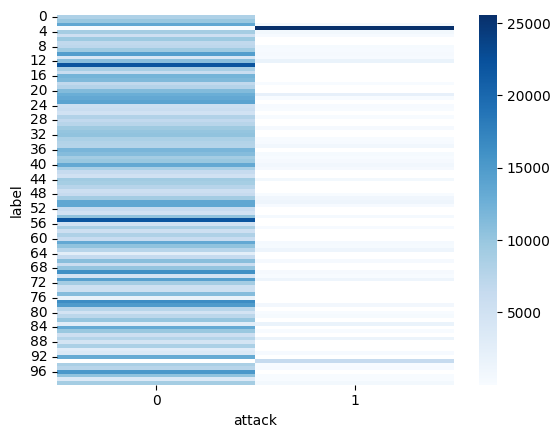

In [ ]:
df_attack_label = data[['label', 'Normal/Attack_discrete']].value_counts(dropna=False).rename_axis(['label', 'attack']).reset_index(name='counts')
sns.heatmap(df_attack_label.pivot('label', 'attack', 'counts'), cmap='Blues')

### Create Markov Model on split data

In [ ]:

def get_time_dataset(df, time_1, time_2):
    data = df[df['Timestamp'].between(time_1, time_2)]
    data['Timestamp'] = df['Timestamp']
    return data

In [ ]:
# data['Normal/Attack_discrete'] = df['Normal/Attack_discrete']

In [ ]:
# get the first attack
data_p = get_time_dataset(data, '2015-12-28 10:29:13', '2015-12-28 15:20:13')

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_19682/389973463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = df['Timestamp']


In [ ]:

df_discrete_p = get_time_dataset(df_discrete, '2015-12-28 10:29:13', '2015-12-28 15:20:13')
df_discrete_p = df_discrete_p.reset_index(drop=True)

y, data_p = get_target_data(df_discrete_p)

k = 100

data_p, centroid = get_data_labelised(data_p, k)


data_p['Normal/Attack_discrete'] = y
data_p['Timestamp'] = df_discrete_p['Timestamp']


/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_19682/389973463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = df['Timestamp']


In [ ]:
data_p['Normal/Attack_discrete'].value_counts()

0    12995
1     4466
Name: Normal/Attack_discrete, dtype: int64

In [ ]:
# data.to_pickle('dataset/data_kmean.pkl')

In [ ]:
data = pd.read_pickle('dataset/data_kmean.pkl')

### Creation of sequence

In [ ]:
cols_dis = cols_discrete.copy()
cols_dis.remove('Normal/Attack')
cols_dis += ['Normal/Attack_discrete']
df[cols_dis].value_counts()

MV101  P101  P102  MV201  P201  P203  P204  P205  P206  MV301  MV302  MV303  MV304  P301  P302  P402  P403  UV401  P501  P602  Normal/Attack_discrete
2      2     1     2      1     2     1     2     1     1      2      1      1      1     2     2     1     2      2     1     0                         405659
1      2     1     2      1     2     1     2     1     1      2      1      1      1     2     2     1     2      2     1     0                         112965
2      1     1     1      1     1     1     1     1     1      1      1      1      1     1     2     1     2      2     1     0                          86725
1      1     1     1      1     1     1     1     1     1      2      1      1      1     2     2     1     2      2     1     0                          72765
2      1     1     1      1     1     1     1     1     1      2      1      1      1     2     2     1     2      2     1     0                          33596
                                                  

In [ ]:
df_test_counts = test[discrete_cols].value_counts().rename_axis(discrete_cols).reset_index(name='counts')
df_train_counts = train[discrete_cols].value_counts().rename_axis(discrete_cols).reset_index(name='counts')

In [ ]:
df_test_counts['state'] = df_test_counts.apply(lambda x: set_sequence(df_test_counts, x), axis=1)
df_train_counts['state'] = df_train_counts.apply(lambda x: set_sequence(df_train_counts, x), axis=1)
df_test_counts['type'] = 'test'
df_train_counts['type'] = 'train'
df_merge = pd.concat([df_test_counts, df_train_counts], axis=0, ignore_index=True)


In [ ]:
all_counts = pd.DataFrame(columns=['state', 'counts'])
for state in duplicated_state:
    df_state = df_merge[df_merge['state'] == state]
    count = df_state['counts'].sum()
    count_test = int(df_merge[(df_merge['state'] == state) & (df_merge['type'] == 'test')]['counts'].values[0])
    count_train = int(df_merge[(df_merge['state'] == state) & (df_merge['type'] == 'train')]['counts'].values[0])
    count_attack = int(df_merge[(df_merge['state'] == state) & (df_merge['state'] == state) & (df_merge['type'] == 'test')]['counts'].values[0])
    
    state = df_state['state'].values[0]
    
    all_counts = pd.concat([all_counts, pd.DataFrame({'state': state, 'counts': count, 'count_test':count_test, 'count_train':count_train}, index=[0])], axis=0, ignore_index=True)
    

In [ ]:
df_merge_attack = pd.merge(all_counts, df_discrete, on='state', how='left')

In [ ]:
df_attack_m = df_merge_attack[['state', 'Normal/Attack_discrete']].value_counts().rename_axis(['state', 'attack']).reset_index(name='counts')

In [ ]:
df_attack_merge = pd.DataFrame(columns=['state', 'count_no_attack', 'count_attack', 'count'])
for state in df_attack_m['state'].unique():
    count_no_attack = len(df_merge_attack[(df_merge_attack['state'] == state) & (df_merge_attack['Normal/Attack_discrete'] == 0)]['counts'])
    # print(count_no_attack)
    count_attack = len(df_merge_attack[(df_merge_attack['state'] == state) & (df_merge_attack['Normal/Attack_discrete'] == 1)]['counts'])
    count = len(df_merge_attack[(df_merge_attack['state'] == state)]['counts'])
    
    dict = {'state': state, 'count_no_attack': count_no_attack, 'count_attack': count_attack, 'count': count}
    df_attack_merge = pd.concat([df_attack_merge, pd.DataFrame(dict, index=[0])], axis=0, ignore_index=True)
    

In [ ]:
df_attack_merge

,state,count_no_attack,count_attack,count
0,344131111122121212112111221221,14646,756,15402
1,354111111121111111111111121221,8588,307,8895
2,354111112221111111111111121221,7535,0,7535
3,344131112222121212112111221221,7348,299,7647
4,344221131122121212112111221221,6989,0,6989
...,...,...,...,...
284,244221111112121212112111221221,2,0,2
285,344231111122121212111011121221,2,0,2
286,354221131121121212111111121221,2,0,2
287,434211112211111111112111221221,2,2,4


In [ ]:
df_merge_cnt = pd.merge(df_merge_attack, df_attack_merge, on='state', how='inner')

In [ ]:
df_attack_cnt = df_merge_cnt.drop_duplicates(subset=['state'])[['state', 'count_test', 'count_train','count_no_attack', 'count_attack', 'count']].reset_index(drop=True)

In [ ]:
df_attack_cnt['count_attack'].sum()

3726

In [ ]:
df_attack_cnt['count_no_attack'].sum()

169279

In [ ]:
df_attack_cnt['count_no_attack'].sum() - df_attack_cnt['count_train'].sum()

112172.0

In [ ]:
df_attack_cnt['count_attack'].sum() / (df_attack_cnt['count_no_attack'].sum() - df_attack_cnt['count_train'].sum())

0.03321684555860643

In [ ]:
df_attack_cnt['count_attack'].sum() + df_attack_cnt['count_no_attack'].sum() - df_attack_cnt['count_train'].sum()

115898.0

In [ ]:
# get the first attack


def get_time_dataset(df, time_1, time_2):
    data = df[df['Timestamp'].between(time_1, time_2)]
    data['Timestamp'] = df['Timestamp']
    return data

data_p = get_time_dataset(df_discrete, '2015-12-28 10:29:13', '2015-12-28 15:20:13')

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_12766/2595259106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = df['Timestamp']


In [ ]:
dict = {
    ''
}

In [ ]:
TIME_WINDOW = 30


In [ ]:
pd.Series(data_p.iloc[2+TIME_WINDOW+1]['label'])

0    83
dtype: int32

In [ ]:

all_sequence = pd.DataFrame()

sequence = data_p.iloc[0:TIME_WINDOW]['state'].tolist()
for i in range(len(data_p)-TIME_WINDOW-1):
    sequence = sequence[1:]
    # sequence.append(data_p.iloc[i+TIME_WINDOW+1]['state'])
    sequence = pd.concat([pd.Series(sequence), pd.Series(data_p.iloc[0+TIME_WINDOW+1]['state'])], axis=0)
    sequence = sequence.reset_index(drop=True)
    # all_sequence = all_sequence.append({'sequence':sequence}, ignore_index=True)
    all_sequence = pd.concat([all_sequence, sequence], axis=1)

all_sequence.columns = ['sequence'] 

In [ ]:
all_sequence

In [ ]:
all_sequence['sequence_str'] = all_sequence['sequence'].apply(lambda x: str(x))

In [ ]:
all_sequence

,sequence,sequence_str
0,"[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
1,"[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
2,"[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
3,"[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
4,"[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]","[83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]"
...,...,...
17425,"[6, 6, 6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6]"
17426,"[6, 6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6]"
17427,"[6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6, 6]","[6, 6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6, 6]"
17428,"[6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6, 6, 47]","[6, 6, 6, 6, 47, 47, 92, 92, 92, 92, 92, 92, 92, 92, 92, 47, 47, 47, 47, 47, 47, 6, 6, 6, 6, 6, 6, 6, 6, 47]"


## The Transition Probability Matrix

In [ ]:
df_prob = (sum_label / len(data_p))
df_prob = np.nan_to_num(df_prob)
df_prob = np.array(df_prob.tolist())

In [ ]:
from hmmlearn import hmm

startprob_prior = df_prob
transmat_prior = transition_matrix
emission_prob_prior = transition_matrix

hmm = hmm.GaussianHMM(n_components=k, covariance_type="full")
# hmm = hmm.BaseHMM(n_components=k)#, startprob_prior=df_prob,  transmat_prior=df)

hmm.startprob_ = startprob_prior
hmm.transmat_ = transmat_prior
hmm.emission_prob_ = emission_prob_prior

# remodel.fit([data['label']])

In [ ]:
from hmmlearn import hmm

# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0, 0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(500)

In [ ]:
X[:X.shape[0] // 2]

In [ ]:
model = hmm.GaussianHMM(n_components=4,
                                covariance_type='full',
                                random_state=3)
model.fit(X[:X.shape[0] // 2])  # 50/50 train/validate
model.decode(X[X.shape[0] // 2:])

(-1107.1877941287978,
 array([1, 3, 0, 3, 0, 3, 0, 2, 2, 2, 2, 3, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2,
        2, 1, 3, 0, 3, 0, 3, 0, 3, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 3, 2,
        1, 1, 2, 1, 2, 1, 1, 3, 0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0,
        1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 0, 2, 2, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 0, 3, 0, 3,
        0, 3, 2, 0, 2, 1, 1, 3, 0, 3, 3, 0, 3, 0, 3, 0, 2, 1, 1, 0, 3, 0,
        3, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 0, 2, 1, 1, 0, 3, 0, 3, 0, 3, 1,
        3, 0, 3, 0, 3, 2, 1, 3, 0, 3, 2, 3, 0, 2, 1, 2, 2, 1, 1, 1, 1, 0,
        3, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 3, 0,
        3, 0, 3, 0, 1, 1, 1, 1]))

In [ ]:
X = [all_sequence.iloc[0]['sequence']]
for i in range(1, len(all_sequence)):
    sequence = all_sequence.iloc[i]['sequence']
    X = np.concatenate([X, [sequence]])
X

array([[83, 83, 83, ..., 83, 83, 83],
       [83, 83, 83, ..., 83, 83, 83],
       [83, 83, 83, ..., 83, 83, 83],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6, 47],
       [ 6,  6,  6, ...,  6, 47, 47]])

In [ ]:
hmm.fit(X)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


GaussianHMM(covariance_type='full', n_components=100)

In [ ]:
arr = hmm.decode(np.array([X[400]]).reshape(30, 1))
arr

(5559.354031900531,
 array([72, 66, 72, 66, 72, 66, 72, 66, 72, 66, 72, 66, 72, 66, 72, 66, 72,
        66, 72, 66, 72, 66, 72, 66, 72, 66, 72, 66, 72, 66]))

In [ ]:
gh = pd.DataFrame(arr[1].tolist())
gh.columns = ['label']

In [ ]:
gh['lab'] = gh['label'].apply(func=lambda x: df_label[df_label['index'] == x]['label'].values[0])

In [ ]:
sequence_str = str(list(gh['lab']))

In [ ]:
all_sequence[all_sequence['sequence_str'] == sequence_str]

,sequence,sequence_str


In [ ]:
new_arr = []
for i in range(len(arr[1])):
    
    new_arr.append(arr[1])

In [ ]:
df_label

,index,label
0,0,1
1,1,2
2,2,3
3,3,7
4,4,9
5,5,22
6,6,24
7,7,32
8,8,36
9,9,39


In [ ]:
arr = hmm.predict_proba(np.array([X[0]])).tolist()
df_arr = pd.DataFrame(arr).T
df_arr.columns = ['predict']

In [ ]:
arr = hmm.decode(np.array([X[0]]).reshape(30, 1))
arr

(5619.6986764768035,
 array([21, 49, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]))

In [ ]:
data_p['label'].value_counts()

7     5101
57    3107
89    1984
65    1910
36    1753
53    1164
68     774
3      566
39     448
9      442
2       54
32      51
1       36
58      16
81      15
71      12
44      11
48       4
62       4
22       4
24       3
51       1
40       1
Name: label, dtype: int64

In [ ]:
all_sequence[all_sequence['sequence_str'] == '[9, 9, 9, 9, 57, 57, 9, 9, 9, 9, 9, 9, 57, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]']

,sequence,sequence_str
0,"[9, 9, 9, 9, 57, 57, 9, 9, 9, 9, 9, 9, 57, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]","[9, 9, 9, 9, 57, 57, 9, 9, 9, 9, 9, 9, 57, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]"


<AxesSubplot:xlabel='label', ylabel='Probability'>

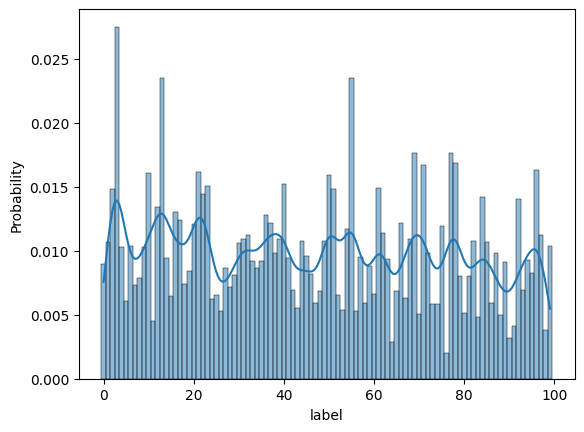

In [ ]:
sns.histplot(data['label'], kde=True, bins=100, stat='probability', discrete=True)

<AxesSubplot:xlabel='Timestamp', ylabel='label'>

/Users/david/SWaT_Analysis_TFE/.env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/david/SWaT_Analysis_TFE/.env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


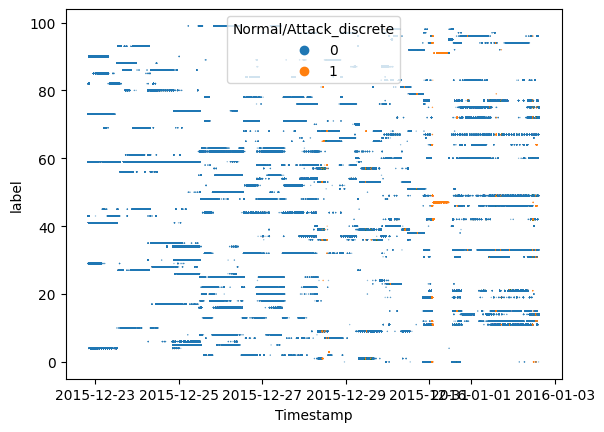

In [ ]:
sns.scatterplot(data=data, x='Timestamp', y='label', hue='Normal/Attack_discrete', alpha=0.5, s=1, linewidth=0)

In [ ]:
sequence_count = all_sequence['sequence_str'].value_counts().rename_axis('sequence').reset_index(name='counts')

In [ ]:
sequence_count

,sequence,counts
0,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",4117
1,"[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]",1810
2,"[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57]",1716
3,"[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]",1073
4,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",537
...,...,...
6033,"[39, 39, 39, 39, 39, 39, 39, 68, 68, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]",1
6034,"[39, 39, 39, 39, 39, 39, 39, 39, 68, 68, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]",1
6035,"[68, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 68, 68, 39, 39, 39, 39]",1
6036,"[68, 68, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 68, 68, 39, 39, 39]",1


In [ ]:
sequence_count[sequence_count['counts'] != 1]

,sequence,counts
0,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",4117
1,"[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]",1810
2,"[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57]",1716
3,"[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]",1073
4,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",537
...,...,...
526,"[7, 89, 89, 89, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",2
527,"[2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",2
528,"[2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]",2
529,"[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 68, 68]",2


# Create Model

## PCA Analysis

In [ ]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

df['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)


X_norm = (df[cols_numeric] - df[cols_numeric].min())/(df[cols_numeric].max() - df[cols_numeric].min())
X_norm = X_norm.fillna(0)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA(n_components=3) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

transformed['Attack/Normal'] = df['Normal/Attack']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


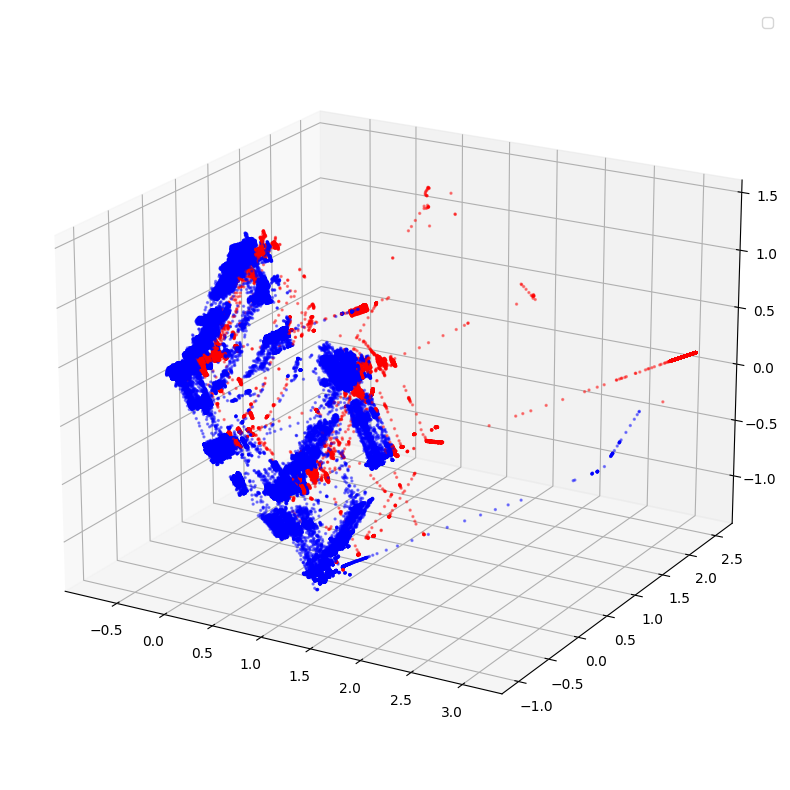

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.view_init(30, 30)
color_ = ['red' if l == 1 else 'blue' for l in transformed['Attack/Normal']]

ax.scatter(transformed[0], transformed[1], transformed[2], c=color_, s=2, alpha=0.4)


# sns.scatterplot(x=transformed[0], y=transformed[1], hue=transformed['Attack/Normal'], palette=['green', 'red'], alpha=0.5, s=5, linewidth=0, legend='full')
plt.legend()
plt.show()

In [ ]:
%%time
from sklearn import datasets
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# fit a k-nearest neighbor model to the data
model = KNeighborsClassifier()
model.fit(X_train, y_train)
print(model)
# make predictions
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

In [ ]:
data_plot = [445.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
420.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
421.0,
424.0,
424.0,
424.0,
420.0,
421.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
420.0,
421.0,
424.0,
424.0,
424.0,
420.0,
421.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
420.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
420.0,
421.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
423.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
420.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
424.0,
428.0,
428.0,
428.0,
428.0,
428.0,
428.0,
435.0,
435.0,
435.0,
414.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
435.0,
442.0,
442.0,
442.0,
442.0,
442.0,
442.0,
442.0,
442.0,
444.0,
420.0,
427.0,
440.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
444.0,
445.0,
446.0,
446.0,
447.0,
447.0,
447.0,
447.0,
447.0,
447.0,
447.0,
449.0,
449.0,
449.0,
449.0,
449.0,
449.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
452.0,
453.0,
453.0,
454.0,
455.0,
455.0,
455.0,
455.0,
456.0,
459.0,
461.0,
461.0,
463.0,
465.0,
467.0,]

In [ ]:
index = [i for i in range(len(data_plot))]

Text(0, 0.5, 'lower-bound')

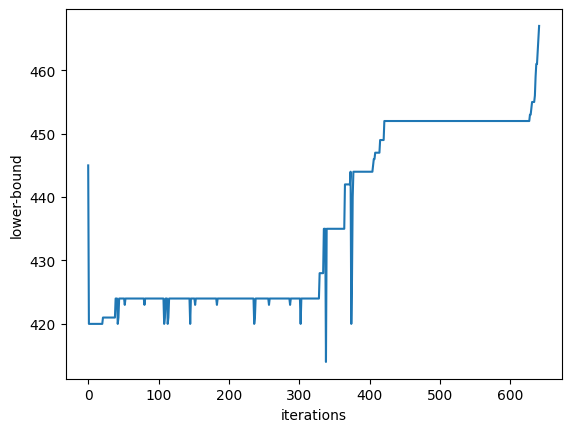

In [ ]:
sns.lineplot(x=index, y=data_plot)
plt.xlabel(xlabel='iterations', fontsize=10)
plt.ylabel(ylabel='lower-bound', fontsize=10)